# 📖 XAI & Classification
- 캡스톤 스타트 23팀 inae park 🐻
- XAI library: captum
- AI library: torchvision
  - torchvision의 models 모듈에 포함된 모델들은 pre-trained models(사전 학습된 모델들)
    - ResNet, VGG, AlexNet, SqueezeNet, DenseNet, Inception 등
  - ImageNet dataset으로 학습됨
    - 1000개의 class
    - 약 1400만 개의 이미지

- torchvision에서 사전 학습된 모델을 로드하는 예시
  -
    ```
    import torchvision.models as models

    # ResNet-50 모델 불러오기 (ImageNet으로 학습된 모델)
    model = models.resnet50(pretrained=True)

    # 모델을 평가 모드로 전환
    model.eval()
    ```
  - pretrained=True 인자를 사용하여 모델을 로드하면, 해당 모델은 사전 학습된 가중치를 포함함
    - 해당 모델을 바로 예측에 사용할 수 있고, 필요에 따라 fine tuning(추가 학습)을 진행해도 됨.
  - pretrained=False로 불러와서 새로 학습시켜도 됨

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os

# root_dir = "PATH/TO/YOUR/DIRECTORY"
root_dir = "/content/gdrive/MyDrive/capstone_start"

# Checking if our specified directory exists
os.path.exists(root_dir)

True

# 📌 Install XAI Tool library
- captum
- details는 아래 link에서 확인
  - https://captum.ai/tutorials/

In [ ]:
#!conda install captum -c pytorch
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# 📌 필요한 라이브러리 불러오기

In [ ]:
# Initial imports
import numpy as np
import torch

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients, GradientShap, Occlusion, LayerGradCam
from captum.attr import visualization as viz
from captum.attr import NoiseTunnel

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 📌 분석할 이미지 셋팅
- 테스트는 학습에 사용되지 않은 이미지 데이터를 이용
- ImageNet 데이터셋에 포함되지 않은 임의의 이미지

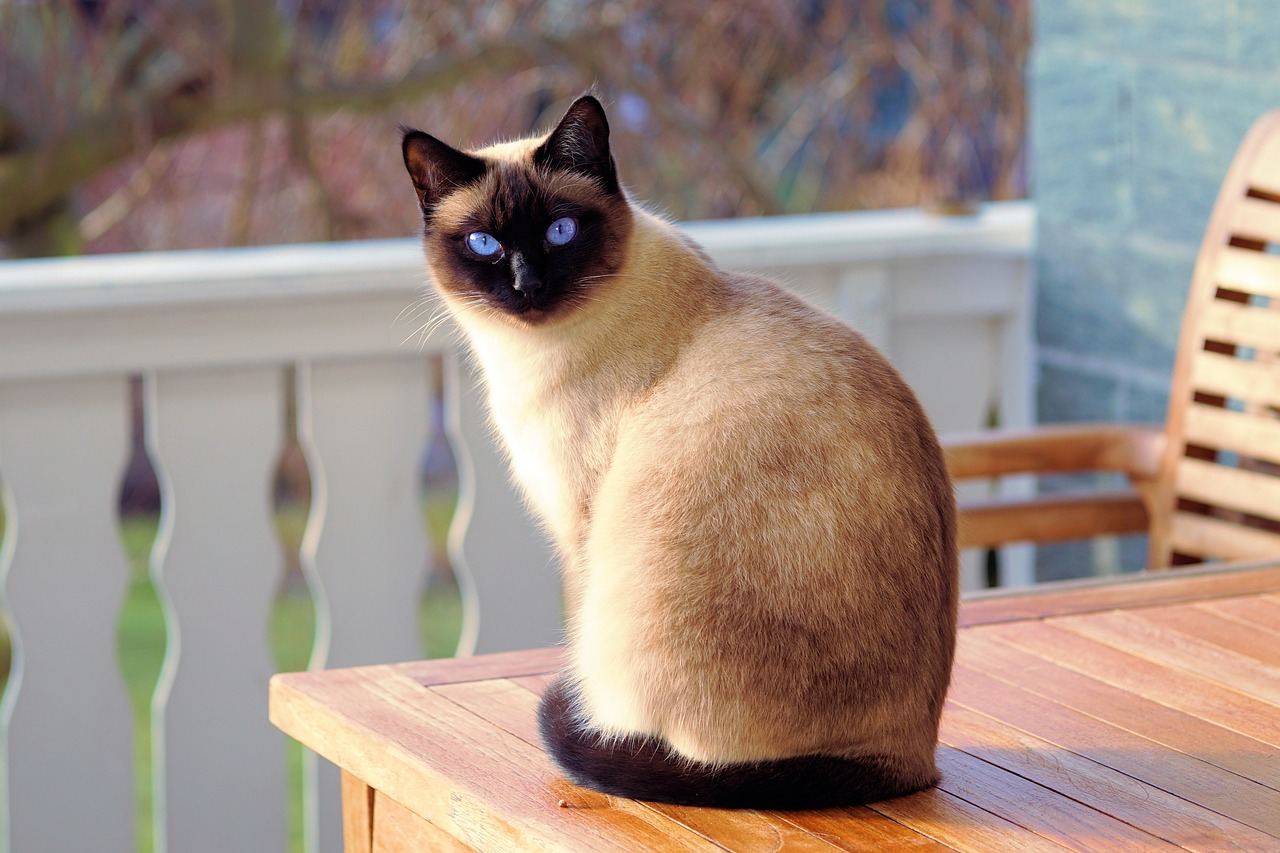

In [ ]:
#img = Image.open('/<YOUR>/<LOCATION>/640px-YellowLabradorLooking_new.jpg')
img = Image.open(f'{root_dir}/Siamese-cat.jpg')
img

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

# 📌 XAI Lab 1
- Model
  - ResNet
- Task
  - Classification (Deep Learning)
- XAI (Attribution Algorithms Captum Supporting)
  - Integrated Gradient in Gradient-based attribution

### TORCHVISION.MODELS
- https://pytorch.org/vision/0.9/models.html
- Classification Model
  - AlexNet
  - VGG
  - ResNet
  - SqueezeNet
  - DenseNet
  - Inception v3
  - GoogLeNet
  - ShuffleNet v2
  - MobileNetV2
  - MobileNetV3
  - ResNeXt
  - Wide ResNet
  - MNASNet

### ✨ 모델 셋팅: **ResNet**

In [ ]:
model = models.resnet18(pretrained=True)

# 현재 model training을 하지는 않을거라 model training에 필요한 것들 비활성화
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 51.4MB/s]


### IMAGENET 1000 Class List
- https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
- Cat Class
   - 281	tabby, tabby cat
   - 282	tiger cat
   - 283	Persian cat
   - 284	Siamese cat, Siamese
   - 285	Egyptian cat

In [ ]:
TARGET_LABEL_IDX = 284  # 샴 고양이 class
ZERO = torch.zeros(input.shape)

ig = IntegratedGradients(model)
attributions_ig = ig.attribute(input,
                               target=TARGET_LABEL_IDX,
                               n_steps=20,
                               baselines=ZERO,)

### ✨ XAI 셋팅: **Integrated Gradient**
$$
\operatorname{IntegratedGrads~}_i(x)::=\left(x_i-x_i^{\prime}\right) \times \int_{\alpha=0}^1 \frac{\partial F\left(x^{\prime}+\alpha \times\left(x-x^{\prime}\right)\right)}{\partial x_i} d \alpha
$$


In [ ]:
attributions_ig = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
input_img = np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0))

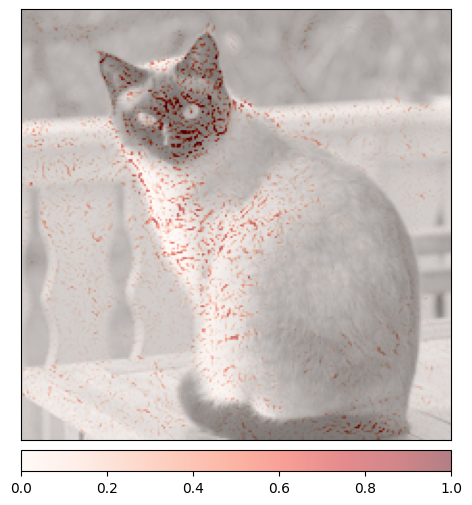

In [ ]:
_ = viz.visualize_image_attr(attributions_ig,
                              input_img,
                              method="blended_heat_map",
                              cmap="Reds",
                              show_colorbar=True,
                              sign="positive",
                              outlier_perc=5)

# 📌 XAI Lab 2
- Model
  - ResNet
- Task
  - Classification (Deep Learning)
- XAI (Attribution Algorithms Captum Supporting)
  - SmoothGrad for Robust Attribution

### ✨ XAI 셋팅: **SmoothGrad**

In [ ]:
nt = NoiseTunnel(ig)
attributions_ig_nt = nt.attribute(input,
                                  nt_samples=10,
                                  nt_type='smoothgrad_sq',
                                  stdevs=1.0,
                                  target=TARGET_LABEL_IDX)

In [ ]:
attributions_ig_nt = np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0))
input_img = np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0))

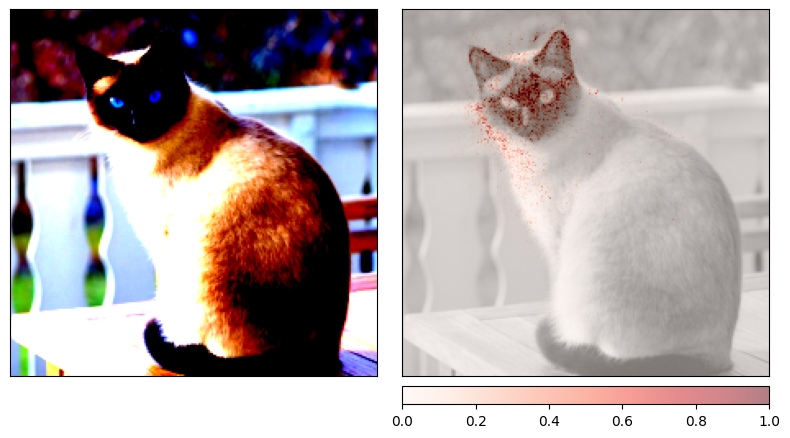

In [ ]:
_ = viz.visualize_image_attr_multiple(attributions_ig_nt,
                                      input_img,
                                      methods=["original_image", "blended_heat_map"],
                                      cmap="Reds",
                                      show_colorbar=True,
                                      signs=["all", "positive"],
                                      outlier_perc=5)

# 📌 XAI Lab 3
- Model
  - ResNet
- Task
  - Classification (Deep Learning)
- XAI (Attribution Algorithms Captum Supporting)
  - Occulusion in Perturbation-based attribution

### ✨ XAI 셋팅: **Occulusion**

In [ ]:
oc = Occlusion(model)
attributions_occ = oc.attribute(input,
                                sliding_window_shapes=(3, 15, 15),
                                strides = (3, 8, 8),
                                target=TARGET_LABEL_IDX,
                                baselines=0)

In [ ]:
attributions_occ = np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0))

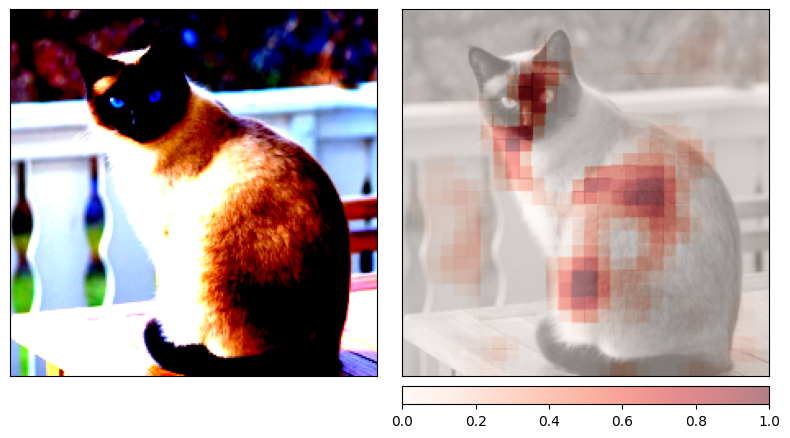

In [ ]:
_ = viz.visualize_image_attr_multiple(attributions_occ,
                                      input_img,
                                      methods=["original_image", "blended_heat_map"],
                                      cmap="Reds",
                                      show_colorbar=True,
                                      signs=["all", "positive"],
                                      outlier_perc=5)

# 📌 XAI Lab 4
- Model
  - GoogLeNet
- Task
  - Classification (Deep Learning)
- XAI (Attribution Algorithms Captum Supporting)
  - Integrated Gradient in Gradient-based

### ✨ 모델 셋팅: **GoogLeNet**

In [ ]:
googlenet = models.googlenet()

# 현재 model training을 하지는 않을거라 model training에 필요한 것들 비활성화
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
TARGET_LABEL_IDX = 284  # 샴 고양이 class
ZERO = torch.zeros(input.shape)

ig = IntegratedGradients(model)
attributions_ig = ig.attribute(input,
                               target=TARGET_LABEL_IDX,
                               n_steps=20,
                               baselines=ZERO,)

### ✨ XAI 셋팅: **Integrated Gradient**

In [ ]:
attributions_ig = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0))
input_img = np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0))

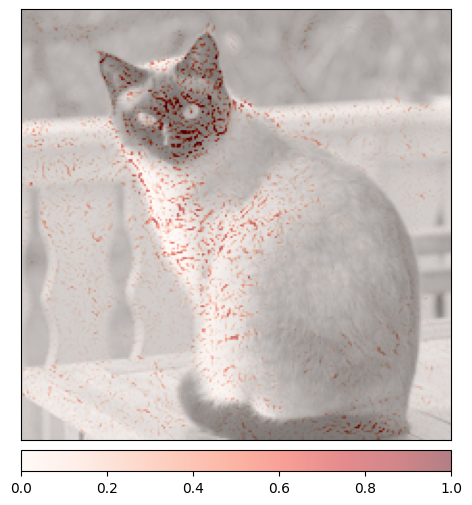

In [ ]:
_ = viz.visualize_image_attr(attributions_ig,
                              input_img,
                              method="blended_heat_map",
                              cmap="Reds",
                              show_colorbar=True,
                              sign="positive",
                              outlier_perc=5)

# 📌 XAI Lab 5
- Model
  - GoogLeNet
- Task
  - Classification (Deep Learning)
- XAI (Attribution Algorithms Captum Supporting)
  - SmoothGrad for Robust Attribution

### ✨ XAI 셋팅: **SmoothGrad**

In [ ]:
nt = NoiseTunnel(ig)
attributions_ig_nt = nt.attribute(input,
                                  nt_samples=10,
                                  nt_type='smoothgrad_sq',
                                  stdevs=1.0,
                                  target=TARGET_LABEL_IDX)

In [ ]:
attributions_ig_nt = np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0))
input_img = np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0))

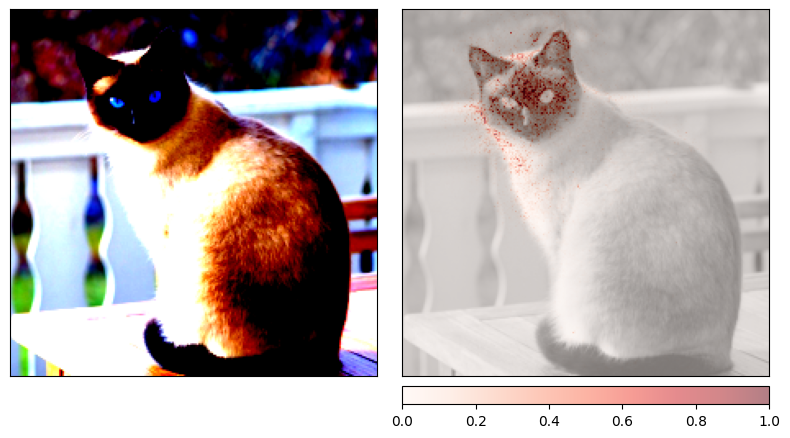

In [ ]:
_ = viz.visualize_image_attr_multiple(attributions_ig_nt,
                                      input_img,
                                      methods=["original_image", "blended_heat_map"],
                                      cmap="Reds",
                                      show_colorbar=True,
                                      signs=["all", "positive"],
                                      outlier_perc=5)

# 📌 XAI Lab 6
- Model
  - GoogLeNet
- Task
  - Classification (Deep Learning)
- XAI (Attribution Algorithms Captum Supporting)
  - Occulusion in Perturbation-based attribution

### ✨ XAI 셋팅: **Occulusion**

In [ ]:
oc = Occlusion(model)
attributions_occ = oc.attribute(input,
                                sliding_window_shapes=(3, 15, 15),
                                strides = (3, 8, 8),
                                target=TARGET_LABEL_IDX,
                                baselines=0)

In [ ]:
attributions_occ = np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0))

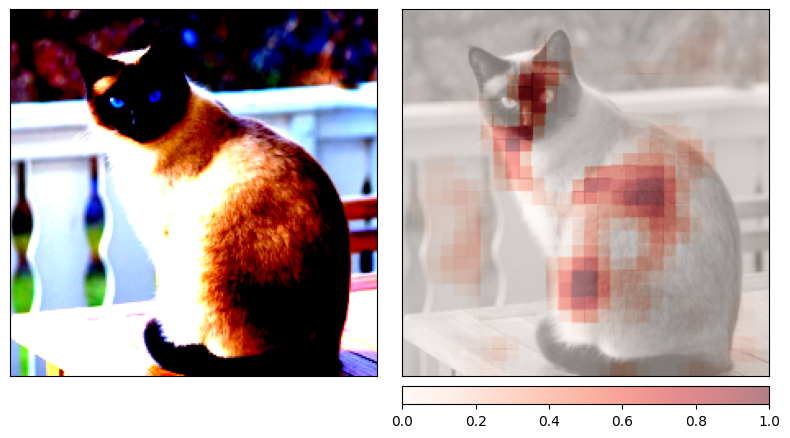

In [ ]:
_ = viz.visualize_image_attr_multiple(attributions_occ,
                                      input_img,
                                      methods=["original_image", "blended_heat_map"],
                                      cmap="Reds",
                                      show_colorbar=True,
                                      signs=["all", "positive"],
                                      outlier_perc=5)